In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import math
import time
from Duty import *
from CarTravel import *
from DSPDataLoader import *

class DSPSC:    
    #sets:
    duties = []             #d element D
    bus_trips = []          #t element Tau
    car_travels = []        #i element C
    car_travel_departures = []           #i element Ć
    car_travel_arrivals = []             #j element Ĉ
    car_departure_times = []             #Times at which staff car can leave the depot (o element O)

    #parameters
    duty_cost = {}      # c_d
    A = {}              # binary matrix A with a_t_d as index
    G = {}              # binary matrix G with g_i_d as index
    H = {}              # binary matrix H where h_i_j indicates if two car travels can be matched as one round trip
    H_tuples = []       # list of tuples (i,j) where i and j can be matched as a pendulum tour (h_i_j = 1)
    v = {}              # Arrival time of car travel i
    u = {}              # departure time of car travel i
    Q = 1               # available staff cars at depot 
    M = 5               # Big number can be set to number of seats of staff car
    depot_node_id= 0    # Id of depot Node


    #Adaptable parameters
    beta = 100           # penalty coefficient for uncovered trips
    
    #Data used for the heuristics
    duty_objects = {}        #list of duty objects @see Duty
    car_travel_objects = {}  #list of CarTravel objects @see CarTravel
    

    
    #loads data from multiple csv files which must have the standard data form provided by Perumal et. al. 2019
    #and are located in the same folder designated by the parameter folder_name
    
    def load_data(self, folder_name, basic_model): 
        assert(isinstance(basic_model, bool))
        
        bus_trips_df = pd.read_csv(folder_name +"\Trips.csv", ";")
        bus_trips_df.set_index("TripID", inplace = True)
        #Load bus_trips
        self.bus_trips = bus_trips_df.index.values.tolist()
        duties_df = pd.read_csv(folder_name + "\Duties.csv", ";")
        duties_df.set_index("DutyID", inplace = True)
        #load duties
        self.duties = duties_df.index.values.tolist()
        #load duty costs as dictionary
        self.duty_cost = duties_df[["Paid time or cost of duty"]].to_dict()["Paid time or cost of duty"]
        #Load car travels as data frame
        car_travels_df = pd.read_csv(folder_name + "\CarTravels.csv", ";")
        #load car travels
        self.car_travels = car_travels_df["CarTravelID"].values.tolist()
        staff_car_df = pd.read_csv(folder_name + "\StaffCar.csv", ";")
        #load available staff cars
        self.Q = staff_car_df["Number of staff cars"].values.tolist()[0]
        
        
        if(basic_model):
            #load depot node id
            self.depot_node_id = staff_car_df["Staff car depot nodeID"].values.tolist()[0]
            #load departing car travels (from depot)
            idx =car_travels_df["Departure nodeID"]==self.depot_node_id
            self.car_travel_departures = car_travels_df.loc[idx]["CarTravelID"].values.tolist()
            #load arriving car travels (to depot)
            self.car_travel_arrivals = car_travels_df.loc[car_travels_df["Arrival nodeID"]==self.depot_node_id]["CarTravelID"].values.tolist()
            #Load set of all departure times of a staff car from the depot
            self.car_departure_times = car_travels_df.loc[idx]["Departure time"].values.tolist()
        
        #Loading car matches df
        car_matches_df = pd.read_csv(folder_name + "\CarMatches.csv", ";")

        #Loading u[i] and v[i]
        car_travels_df.set_index("CarTravelID", inplace= True)
        if(basic_model):
            self.u = car_travels_df[["Departure time"]].to_dict()["Departure time"]
            self.v = car_travels_df[["Arrival time"]].to_dict()["Arrival time"]
        
        #creating staff car matching tuples
        self.H_tuples = create_H_tuples (car_matches_df)
        
        #create 2D binary matricies as dictionarys @see DSPDataLoader
        if(basic_model):
            self.A = create_dictionary (self.duties, self.bus_trips, duties_df, "Trips")
            self.H = create_H_dictionary(self.car_travels, self.H_tuples)
        self.G = create_dictionary (self.duties, self.car_travels, duties_df, "Car travels")
        
        
        #create duty and car travel objects for the greedy heuristics
        if(not basic_model):
            self.duty_objects = load_duties(duties_df)
            self.car_travel_objects = load_car_travels(car_travels_df)
        
    #Solves the basic DSPSC problem with the Gurobi solver module from www.gurobi.com
    def solve_with_gurobi(self, time_limit):
        return solve_basic_dspsc_model(self.duties, self.duty_cost, self.bus_trips, self.car_travels, self.car_travel_departures,
                                self.car_travel_arrivals, self.car_departure_times, self.H_tuples, self.u, 
                                self.v, self.beta,self.A, self.G, self.H, self.M, self.Q, time_limit, None)
        
    #Solves the DSPSC problem with a greedy heuristic introduced by Perumal et. al. 2019. 
    def solve_with_greedy_heuristic(self, TIME_LIMIT):
        return greedy_heuristic(self.duty_objects, self.bus_trips, self.car_travel_objects, self.G, self.H_tuples, self.beta, TIME_LIMIT)
    
    #Checks if greedy solution is feasable
    def check_greedy_heuristic(self, time_limit, s):
        return solve_basic_dspsc_model(self.duties, self.duty_cost, self.bus_trips, self.car_travels, self.car_travel_departures,
                                self.car_travel_arrivals, self.car_departure_times, self.H_tuples, self.u, 
                                self.v, self.beta,self.A, self.G, self.H, self.M, self.Q, time_limit, s)
        
   

        

# Basic DSPSC Model

In [2]:

def solve_basic_dspsc_model(duties, duty_cost, bus_trips, car_travels, car_travel_departures, car_travel_arrivals, 
                            car_departure_times, H_tuples, u, v, beta, A, G, H, M, Q, time_limit, s):
    start_time = time.time()
    #construct model
    m = Model()

    #create variables
    x_d = m.addVars(duties, vtype=GRB.BINARY)
    y_t = m.addVars(bus_trips, vtype=GRB.BINARY)
    z_i = m.addVars(car_travels, vtype=GRB.BINARY)
    s_i_j = m.addVars(car_travel_departures, car_travel_arrivals, vtype=GRB.BINARY)

    #(2)set Objective
    obj = (quicksum(duty_cost[duty] * x_d[duty] for duty in duties) 
           + beta*quicksum(y_t[bus_trip] for bus_trip in bus_trips))

    m.setObjective(obj,GRB.MINIMIZE)

    #set Constraints

    #(3)
    m.addConstrs(quicksum(A[duty][bus_trip]*x_d[duty] for duty in duties) + y_t[bus_trip] >= 1 for bus_trip in bus_trips)

    #(4)
    m.addConstrs(quicksum(G[duty][car_travel]*x_d[duty] for duty in duties)
                <= z_i[car_travel]* M for car_travel in car_travels)

    #(5)
    m.addConstrs(quicksum(G[duty][car_travel]*x_d[duty] for duty in duties)
                >= z_i[car_travel] for car_travel in car_travels)

    #(6)
    m.addConstrs(quicksum(H[car_travel_depart][car_travel_arriv] *s_i_j[car_travel_depart,car_travel_arriv] 
                          for car_travel_arriv in car_travel_arrivals) ==  z_i[car_travel_depart] 
                          for car_travel_depart in car_travel_departures)

    #(7)
    m.addConstrs(quicksum(H[car_travel_depart][car_travel_arriv] *s_i_j[car_travel_depart,car_travel_arriv] 
                          for car_travel_depart in car_travel_departures) ==  z_i[car_travel_arriv] 
                          for car_travel_arriv in car_travel_arrivals)

    #(8)
    for o in car_departure_times:
        P = [(i,j) for i,j in H_tuples if u[i] <= o and v[j]>= 0]
        m.addConstr(quicksum(s_i_j[i,j] for i,j in P) <= Q)
        
    # (additional constraints)
    if (s != None):
        for key in s:
            m.addConstr(x_d[key]==1)
    
    
    #Set Paramters
    
    m.setParam(GRB.Param.TimeLimit, time_limit)
    m.setParam("OutputFlag", 1)
    
    m.optimize() 
    
    return (time.time()-start_time, m.objVal, m.MIPGap)


# Greedy Heuristic

In [3]:
# Finds an initial solution for the DSPSC Model introduced by Perumal et al. (2019)
def greedy_heuristic(duties, bus_trips, car_travels, G , H_tuples, beta, TIME_LIMIT):
    start_time = time.time()
    s = {}
    q = {}
    bus_trips_covered = set()
    #keep track over car travel matches in solution
    matches = set()
    matches_prime = set()
    
    while (len(bus_trips_covered)!= len(bus_trips)):
        d = arg_min_duty(duties,bus_trips_covered, beta)
        q[d.get_id()] = d
        E = d.get_car_travels()
        while(len(E) != 0):
            invalid_duty = False
            for i in E:
                F = [item[1] for item in H_tuples if item[0] == i]
                if (len(F) != 0):
                    j = arg_min_car_travel(i, F, car_travels)
                    matches_prime.add((i,j))
                    G_prime = select_matching_duties(j, G, duties)
                    if(not len(G_prime)==0):# if matching car travel is not used by any duty
                        w = arg_min_duty(G_prime, bus_trips_covered,beta)
                        q[w.get_id()] = w
                else:
                    duties.pop(d.get_id())
                    q = {}
                    matches_prime = set()
                    invalid_duty = True
                    break
            if(invalid_duty):
                break
            E = update_E(matches, matches_prime, q)
            
        if(len(q) > 0):
            s = merge(s,q)
            bus_trips_covered = list(set().union(bus_trips_covered, unify_bus_trips(q)))
            matches = matches.union(matches_prime)
            matches_prime = set()
            q = {}
        if(time.time()> start_time + TIME_LIMIT):
            break   
            
        OFV = compute_cost(s, bus_trips_covered, bus_trips, beta)
    
    return [time.time() - start_time, OFV, s]
                    

## Helper Methods Greedy Heuristic

In [4]:

# Returns the duty with the smallest delta function @see Duty from a list of duties
def arg_min_duty(duties, bus_trips_covered, beta):
    assert(len(duties) > 0)
    candidate = None
    best_cost = math.inf
    current_cost = math.inf
    for duty in duties:
        current_cost = duties[duty].delta_cost_function(bus_trips_covered, beta)
        if (best_cost > current_cost):
            best_cost = current_cost
            candidate = duties[duty]
    assert (candidate != None and best_cost != math.inf)
    
    return candidate

# Returns the car travel with the smallest cost function @see CarTravel from a list of car_travels
def arg_min_car_travel(i, F, car_travels):
    assert(len(F) > 0)
    candidate = None
    best_cost = math.inf
    current_cost = math.inf
    for j in F:
        current_cost = car_idle_time(car_travels[i], car_travels[j])
        if (best_cost > current_cost):
            best_cost = current_cost
            candidate = j
    assert (candidate != None and best_cost != math.inf)
    
    return candidate

#Computes the time a staff car is parked at a certain node. 
def car_idle_time(i, j):
    return j.get_departure_time() - i.get_arrival_time()


# Selects a dictionary of duties where duty w is selected if g_j_w = 1
def select_matching_duties(j, G, duties):
    tmp = {}
    for key in duties:
        if (G[key][j] == 1): 
            tmp[key] = duties[key]
    return tmp

# Returns a list of car travel ids which are unmatched in the current solution (not in q nor in s)
def update_E(matches, matches_prime, q):
    new_car_travels = set()
    for key in q:
        new_car_travels.union(set(q[key].get_car_travels()))
    return have_no_matches(matches_prime, matches, new_car_travels)

#Returns a set of unmatched car travels
def have_no_matches(matches_prime, matches, new_car_travels):
    unmatched = set()
    for key in new_car_travels:
        if(not key_appears(matches_prime, matches, key)):
            unmatched.add(key)
    return unmatched

#Checks if a key (only first element of tuple) appears in the two sets matches_prime and matches. If not returns False            
def key_appears(matches_prime, matches, key):
    
    for element in matches_prime:
        if(element[0] == key):
            return True
    for element in matches:
        if(element[0] == key):
            return True
    return False 

#Merges two dictionaries with unique entrys        
def merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res  

#Returns unordered list of bus trips with repetable values.
def unify_bus_trips(dict1):
    assert (len(dict1) > 0 )
    tmp = []
    for key in dict1:
        tmp.extend(dict1[key].get_bus_trips())
    assert (len(tmp) > 0)
    return tmp

#Computes cost of basic DSPSC model objecitve function from a greedy heuristic solution
def compute_cost(solution, bus_trips_covered, bus_trips, beta):
    cost = 0
    for duty in solution:
        cost += solution[duty].get_cost()
    cost += beta*len(set(bus_trips).difference(bus_trips_covered))
    
    return cost

## Testing Heuristic

In [5]:
import unittest
 
class TestHeuristic(unittest.TestCase):
    
    model = DSPSC()
    
    #Sets
    def set_up_instance1(self):
        self.model.load_data("Instance1", False)
 
    #Duty 430 should be choosen over duty 1
    def testing_arg_min_duty(self):
        self.set_up_instance1()
        dict1 = {}
        for key in [1,430]:
            dict1[key] = self.model.duty_objects[key]
        candidate = arg_min_duty(dict1, set([1,4]), 100)
        self.assertEqual(candidate, dict1[430] )
        
    def testing_construction_of_F(self):
        self.set_up_instance1()
        H_tuples = self.model.H_tuples
        i = 1098
        F = [item[1] for item in H_tuples if item[0] == i]
        self.assertEqual(F[0], 389)
        
    
    def testing_arg_min_car_travel(self):
        self.set_up_instance1()
        dict1 = {}
        i = 1
        for key in [2,3]:
            dict1[key] = self.model.car_travel_objects[key]
        candidate = arg_min_car_travel(1, dict1, self.model.car_travel_objects)
        self.assertEqual(candidate, 2)
        
    
        
#Running all tests
unittest.main(argv=[''], verbosity=2, exit=False)

testing_arg_min_car_travel (__main__.TestHeuristic) ... ok
testing_arg_min_duty (__main__.TestHeuristic) ... ok
testing_construction_of_F (__main__.TestHeuristic) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.669s

OK


# Performance Analysis

### With Gurobi

In [6]:
instances = ["Instance1", "Instance2","Instance3", "Instance4" ]  #,"Instance5","Instance6" did not end
#time limit in seconds
time_limit = 300
#solutions
solution = {}
timegraph = []
OFV = []
MIPGap = []
number_of_duties = []
number_of_bus_trips = []
number_of_car_travels = []

for instance in instances:
    model = DSPSC()
    model.load_data(instance, True)
    number_of_duties.append(len(model.duties))
    number_of_bus_trips.append(len(model.bus_trips))
    number_of_car_travels.append(len(model.car_travels))
    #solve the instance
    solution[instance] = model.solve_with_gurobi(time_limit)
    print(str(instance)+  ", Time: " + str(solution[instance][0]) + ", OFV: " + str(solution[instance][1]) 
          + ", MIPGap: " + str(solution[instance][2]))
    timegraph.append(str(solution[instance][0]))
    OFV.append(str(solution[instance][1]))
    MIPGap.append(str(solution[instance][2])) 

Academic license - for non-commercial use only
Changed value of parameter TimeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 244 rows, 1856 columns and 10459 nonzeros
Variable types: 0 continuous, 1856 integer (1856 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2300.0000000
Presolve removed 156 rows and 1713 columns
Presolve time: 0.03s
Presolved: 88 rows, 143 columns, 565 nonzeros
Variable types: 0 continuous, 143 integer (143 binary)

Root relaxation: objective 1.990427e+03, 76 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1990.42667    0   38 2300.00000 1990.42667  13.5% 

     0     0 12797.4758    0   94 13047.0000 12797.4758  1.91%     -   27s
     0     0 12797.4758    0  145 13047.0000 12797.4758  1.91%     -   27s
     0     0 12797.4758    0  145 13047.0000 12797.4758  1.91%     -   28s
     0     0 12797.4758    0  126 13047.0000 12797.4758  1.91%     -   29s
     0     0 12797.4758    0  130 13047.0000 12797.4758  1.91%     -   29s
     0     0 12797.4758    0  108 13047.0000 12797.4758  1.91%     -   29s
     0     0 12797.4758    0   97 13047.0000 12797.4758  1.91%     -   29s
     0     0 12797.4758    0  134 13047.0000 12797.4758  1.91%     -   29s
     0     0 12797.4758    0   96 13047.0000 12797.4758  1.91%     -   29s
     0     0 12797.4758    0   95 13047.0000 12797.4758  1.91%     -   29s
     0     0 12825.4908    0  129 13047.0000 12825.4908  1.70%     -   29s
     0     0 12825.7590    0  124 13047.0000 12825.7590  1.70%     -   30s
     0     0 12833.9389    0  144 13047.0000 12833.9389  1.63%     -   30s
     0     0 12833.9389  

     0     0 12959.5000    0   59 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   54 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   54 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   34 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   57 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   65 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   23 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   64 12993.0000 12959.5000  0.26%     -   36s
     0     0 12959.5000    0   63 12993.0000 12959.5000  0.26%     -   36s
     0     0 12961.5000    0   23 12993.0000 12961.5000  0.24%     -   36s
     0     0 12970.0000    0   49 12993.0000 12970.0000  0.18%     -   36s

Cutting planes:
  Cover: 5
  Clique: 11
  MIR: 28
  Zero half: 6

Explored 1 nodes (65220 simplex iterations) in 36.47 seconds
Thread count was 4 (of 4 available processors)


     0     0 23287.2990    0  266 23364.0000 23287.2990  0.33%     -  186s
     0     0 23287.2990    0  224 23364.0000 23287.2990  0.33%     -  187s
     0     0 23287.2990    0  238 23364.0000 23287.2990  0.33%     -  187s
     0     0 23287.2990    0  259 23364.0000 23287.2990  0.33%     -  187s
     0     0 23287.2990    0  258 23364.0000 23287.2990  0.33%     -  188s
     0     0 23311.1235    0  215 23364.0000 23311.1235  0.23%     -  188s
     0     0 23331.6487    0  168 23364.0000 23331.6487  0.14%     -  188s
     0     0     cutoff    0      23364.0000 23364.0000  0.00%     -  188s

Cutting planes:
  Gomory: 5
  Cover: 49
  Clique: 33
  MIR: 108
  Zero half: 9

Explored 1 nodes (85068 simplex iterations) in 188.36 seconds
Thread count was 4 (of 4 available processors)

Solution count 4: 23364 25790 25817 27900 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.336400000000e+04, best bound 2.336400000000e+04, gap 0.0000%
Instance4, Time: 654.2598941326141, OFV: 23

### Basic Model: Graphic of instance running time

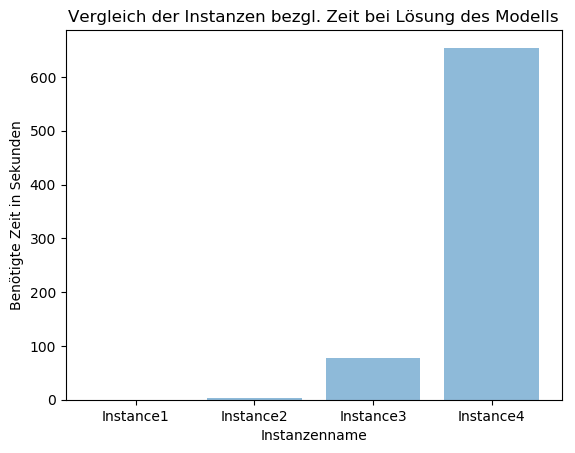

In [15]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

instances = ["Instance1", "Instance2", "Instance3", "Instance4"]
timegraph = [float(x) for x in timegraph]
OFV = [float(x) for x in OFV]
MIPGap = [float(x) for x in MIPGap]
 
objects = (instances)
y_pos = np.arange(len(objects))
performance = (timegraph)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Benötigte Zeit in Sekunden')
plt.xlabel('Instanzenname')
plt.title('Vergleich der Instanzen bezgl. Zeit bei Lösung des Modells')
 
plt.show();

### Basic Model: Table

In [8]:
import pandas as pd
df=pd.DataFrame({'Instance No':instances,'Duties': number_of_duties,'Bus trips': number_of_bus_trips,
                 'CarTravels':number_of_car_travels,'Time (s)':timegraph,
                "OFV_Kosten":OFV,"Mip Gap (%)":MIPGap})
df

,Instance No,Duties,Bus trips,CarTravels,Time (s),OFV_Kosten,Mip Gap (%)
0,Instance1,754,23,65,0.224132,2094.0,0.0
1,Instance2,8880,39,100,2.958673,2956.0,0.0
2,Instance3,41908,152,302,77.998956,12993.0,0.0
3,Instance4,195972,279,710,654.259894,23364.0,0.0


In [9]:
with open('results_basic_model.tex','w') as tf:
    tf.write(df.to_latex(index=False))

### With greedy heuristic

In [10]:
instances_h = ["Instance1", "Instance2"]  #For the other instances the heuristic does not terminate
#time limit in seconds
time_limit = 300
#solutions
solution_h = {}
timegraph_h = []
OFV_h = []
number_of_duties_h = []
number_of_bus_trips_h = []
number_of_car_travels_h = []
feasability_check = []

for instance in instances_h:
    model = DSPSC()
    model.load_data(instance, False)
    number_of_duties_h.append(len(model.duties))
    number_of_bus_trips_h.append(len(model.bus_trips))
    number_of_car_travels_h.append(len(model.car_travels))
    #solve the instance
    solution_h[instance] = model.solve_with_greedy_heuristic(time_limit)
    print(str(instance)+  ", Time: " + str(solution_h[instance][0]) + ", OFV: " + str(solution_h[instance][1]))
    timegraph_h.append(str(solution_h[instance][0]))
    OFV_h.append(str(solution_h[instance][1]))
    
#check feasability with gurobi solver
for instance in instances_h:
    try:
        model.load_data(instance, True)
        feasability_check = model.check_greedy_heuristic(time_limit, solution_h[instance][2])
    except:
        print(str(instance) + ": violates constraint(s)/infeasable")
    

Instance1, Time: 0.031222820281982422, OFV: 2650
Instance2, Time: 0.2655637264251709, OFV: 4158
Changed value of parameter TimeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 252 rows, 1856 columns and 10467 nonzeros
Variable types: 0 continuous, 1856 integer (1856 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 51 rows and 947 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Instance1: violates constraint(s)/infeasable
Changed value of parameter TimeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  

### Heuristic: Graphic of instance running time

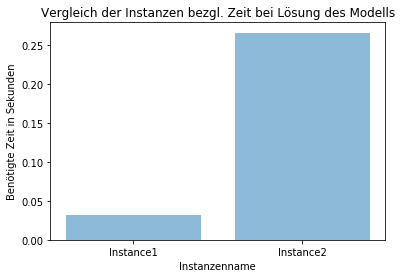

In [11]:
import matplotlib.pyplot as plt_h
timegraph_h = [float(x) for x in timegraph_h]
OFV_h = [float(x) for x in OFV_h]

 
objects_h = (instances_h)
y_pos = np.arange(len(objects_h))
performance = (timegraph_h)
 
plt_h.bar(y_pos, performance, align='center', alpha=0.5)
plt_h.xticks(y_pos, objects_h)
plt_h.ylabel('Benötigte Zeit in Sekunden')
plt_h.xlabel('Instanzenname')
plt_h.title('Vergleich der Instanzen bezgl. Zeit bei Lösung des Modells')
 
plt_h.show();

### Heuristic: Table

In [12]:
import pandas as pd
df_h=pd.DataFrame({'Instance No':instances_h,'Duties': number_of_duties_h,'Bus trips': number_of_bus_trips_h,
                 'CarTravels':number_of_car_travels_h,'Time (s)':timegraph_h,
                "OFV_Kosten":OFV_h})
df_h

,Instance No,Duties,Bus trips,CarTravels,Time (s),OFV_Kosten
0,Instance1,754,23,65,0.031223,2650.0
1,Instance2,8880,39,100,0.265564,4158.0


In [13]:
with open('results_heuristic.tex','w') as tf:
    tf.write(df.to_latex(index=False))

# Comparing Basic Model with Heuristic

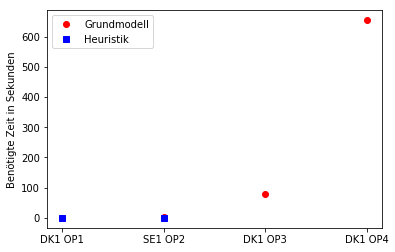

In [14]:
import matplotlib.pyplot as plt_comb
instances = ["DK1 OP1","SE1 OP2","DK1 OP3","DK1 OP4"]
plt_comb.plot(instances, timegraph, 'ro', label='Grundmodell')
plt_comb.plot(instances[:2], timegraph_h, 'bs', label='Heuristik')
plt_comb.ylabel('Benötigte Zeit in Sekunden')
plt_comb.legend()
plt.show()